In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
Data=pd.read_excel('Airlines+Data.xlsx')
Data

Month  Passengers
0  1995-01-01         112
1  1995-02-01         118
2  1995-03-01         132
3  1995-04-01         129
4  1995-05-01         121
..        ...         ...
91 2002-08-01         405
92 2002-09-01         355
93 2002-10-01         306
94 2002-11-01         271
95 2002-12-01         306

[96 rows x 2 columns]

In [10]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [8]:
Data.describe()

Passengers
count   96.000000
mean   213.708333
std     71.918216
min    104.000000
25%    156.000000
50%    200.000000
75%    264.750000
max    413.000000

In [14]:
Data["Date"] = pd.to_datetime(Data.Month,format="%b-%y")
#look for c standard format codes

# Extracting Day, weekday name, month name, year from the Date column using 
# Date functions from pandas 

Data["month"] = Data.Date.dt.strftime("%b") # month extraction
Data["year"] = Data.Date.dt.strftime("%Y") # year extraction
Data.head()


Month  Passengers       Date month  year
0 1995-01-01         112 1995-01-01   Jan  1995
1 1995-02-01         118 1995-02-01   Feb  1995
2 1995-03-01         132 1995-03-01   Mar  1995
3 1995-04-01         129 1995-04-01   Apr  1995
4 1995-05-01         121 1995-05-01   May  1995

<AxesSubplot:xlabel='month', ylabel='year'>

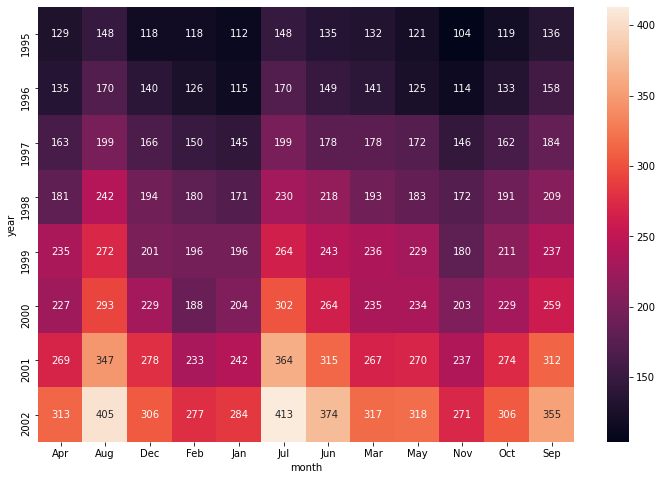

In [13]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=Data,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values


<AxesSubplot:xlabel='year', ylabel='Passengers'>

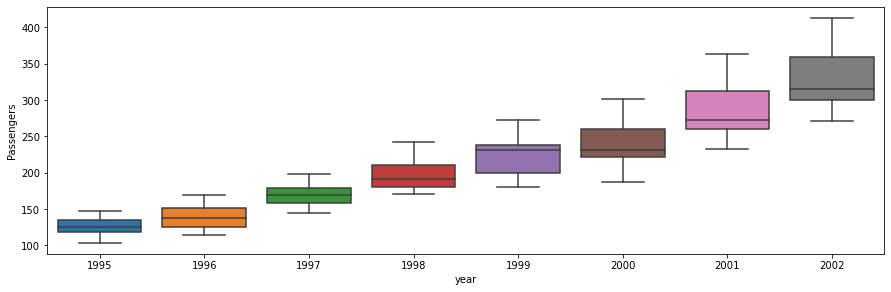

In [17]:
# Boxplot for ever
plt.figure(figsize=(15,10))

plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=Data)


In [20]:
month_dummies = pd.DataFrame(pd.get_dummies(Data['month']))
airline = pd.concat([Data,month_dummies],axis = 1)
airline.head()

Month  Passengers       Date month  year  Apr  Aug  Dec  Feb  Jan  Jul  \
0 1995-01-01         112 1995-01-01   Jan  1995    0    0    0    0    1    0   
1 1995-02-01         118 1995-02-01   Feb  1995    0    0    0    1    0    0   
2 1995-03-01         132 1995-03-01   Mar  1995    0    0    0    0    0    0   
3 1995-04-01         129 1995-04-01   Apr  1995    1    0    0    0    0    0   
4 1995-05-01         121 1995-05-01   May  1995    0    0    0    0    0    0   

   Jun  Mar  May  Nov  Oct  Sep  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    1    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    1    0    0    0

In [21]:
airline["t"] = np.arange(1,97)
airline["t_squared"] = airline["t"]*airline["t"]
airline["log_Passengers"] = np.log(airline["Passengers"])
airline.columns
airline.head()

Month  Passengers       Date month  year  Apr  Aug  Dec  Feb  Jan  Jul  \
0 1995-01-01         112 1995-01-01   Jan  1995    0    0    0    0    1    0   
1 1995-02-01         118 1995-02-01   Feb  1995    0    0    0    1    0    0   
2 1995-03-01         132 1995-03-01   Mar  1995    0    0    0    0    0    0   
3 1995-04-01         129 1995-04-01   Apr  1995    1    0    0    0    0    0   
4 1995-05-01         121 1995-05-01   May  1995    0    0    0    0    0    0   

   Jun  Mar  May  Nov  Oct  Sep  t  t_squared  log_Passengers  
0    0    0    0    0    0    0  1          1        4.718499  
1    0    0    0    0    0    0  2          4        4.770685  
2    0    1    0    0    0    0  3          9        4.882802  
3    0    0    0    0    0    0  4         16        4.859812  
4    0    0    1    0    0    0  5         25        4.795791

In [26]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Passengers",data=airline)

<AxesSubplot:xlabel='year', ylabel='Passengers'>

## Splitting data

In [25]:
Train = airline.head(80)
Test = airline.tail(12)

In [27]:
import statsmodels.formula.api as smf 
#linear 
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  52.161082265128286


In [29]:
#Exponential

Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  45.69753304791885


In [30]:
#Quadratic

Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  45.60305527291764


In [31]:
#Additive seasonality 

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  137.38569683837977


In [32]:
#Additive seasonability Quadratic

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 26.798376686226774


In [33]:
#Multiplicative Seasonality

Mul_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 143.88334727021262


In [34]:
#Multiplicative Additive Seasonality

Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 10.674140223099062


In [35]:
#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

MODEL  RMSE_Values
6  rmse_Mult_add_sea    10.674140
4  rmse_add_sea_quad    26.798377
2          rmse_Quad    45.603055
1           rmse_Exp    45.697533
0        rmse_linear    52.161082
3       rmse_add_sea   137.385697
5      rmse_Mult_sea   143.883347

In [38]:
data = [['2003-01-01', 'Jan'], ['2003-02-01', 'Feb'], ['2003-03-01', 'Mar'],['2003-04-01', 'Apr'],['2003-5-01', 'May'],['2003-06-01', 'Jun'],
        ['2003-07-01', 'Jul'],['2003-08-01', 'Aug'],['2003-09-01', 'Sep'],['2003-10-01', 'Oct'],['2003-11-01', 'Nov'],['2003-12-01', 'Dec']]
forecast = pd.DataFrame(data, columns = ['Date', 'Months'])
forecast

Date Months
0   2003-01-01    Jan
1   2003-02-01    Feb
2   2003-03-01    Mar
3   2003-04-01    Apr
4    2003-5-01    May
5   2003-06-01    Jun
6   2003-07-01    Jul
7   2003-08-01    Aug
8   2003-09-01    Sep
9   2003-10-01    Oct
10  2003-11-01    Nov
11  2003-12-01    Dec

In [39]:
# Create dummies and T and T-Squared columns

dummies = pd.DataFrame(pd.get_dummies(forecast['Months']))
forecast1 = pd.concat([forecast,dummies],axis = 1)

forecast1["t"] = np.arange(1,13)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"] 
print("\nAfter Dummy, T and T-Square\n\n",forecast1.head())



After Dummy, T and T-Square

          Date Months  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  \
0  2003-01-01    Jan    0    0    0    0    1    0    0    0    0    0    0   
1  2003-02-01    Feb    0    0    0    1    0    0    0    0    0    0    0   
2  2003-03-01    Mar    0    0    0    0    0    0    0    1    0    0    0   
3  2003-04-01    Apr    1    0    0    0    0    0    0    0    0    0    0   
4   2003-5-01    May    0    0    0    0    0    0    0    0    1    0    0   

   Sep  t  t_squared  
0    0  1          1  
1    0  2          4  
2    0  3          9  
3    0  4         16  
4    0  5         25  


In [41]:
# Forecasting using Multiplicative Additive Seasonality Model

model_full = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data =airline).fit()
pred_new  = pd.Series(model_full.predict(forecast1))

forecast1["Forecasted_log"] = pd.Series(pred_new)
forecast1['Forecasted_Passengers'] = np.exp(forecast1['Forecasted_log'])

In [42]:
# Final Prediction for next 12 months

Final_predict = forecast1.loc[:, ['Date', 'Forecasted_Passengers']] 
Final_predict

Date  Forecasted_Passengers
0   2003-01-01             109.176148
1   2003-02-01             110.331245
2   2003-03-01             127.315234
3   2003-04-01             123.200587
4    2003-5-01             122.399578
5   2003-06-01             138.536397
6   2003-07-01             154.066959
7   2003-08-01             153.741209
8   2003-09-01             137.693733
9   2003-10-01             120.894736
10  2003-11-01             106.109309
11  2003-12-01             121.633998